In [5]:
%matplotlib widget

import os
import sys
from pathlib import Path
import numpy as np
from netpyne import sim
from neuron import h
from matplotlib import pyplot as plt
import tmsneurosim

# plt.switch_backend('TkAgg')

Directories

In [6]:
study = "WeiseEtAl2023"
cur_path = os.getcwd()
rootFolder = str(Path(os.path.abspath('')))
print(cur_path)
cellFolder = f"{rootFolder}/tmsneurosim/nrn/cells/cells_hoc"
folder = sorted(os.listdir(cellFolder))
#print(folder)
# for cell in folder:
#     print(f"\"{cell}\": cells.{cell}")
celltypes = [
    "L1_NGC-DA",
    "L23_PC",
    "L23_SBC",
    "L4_LBC_cAC",
    "L4_LBC_cNAC",
    "L4_MC",
    "L4_SS",
    "L5_LBC",
    "L5_TTPC2",
    "L6_TPC",
]
cell_library = {}
for i, l in enumerate(celltypes):
    cell_library[l] = folder[i * 5 : (i + 1) * 5]

c:\Users\jacob\Documents\Work\NetPyNE\TMS_Stimulation


nrnivmodl

In [7]:
os.chdir(f"{rootFolder}/data/{study}/mechanisms")
os.system("nrnivmodl")
os.chdir(cur_path)
os.system(f"xcopy /s/y {rootFolder}/data/{study}/mechanisms\\nrnmech.dll")

4

Set up sim


Start time:  2024-07-19 12:48:11.076052

Creating network of 1 cell populations on 1 hosts...
  Number of cells on node 0: 1 
  Done; cell creation time = 0.11 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 8 types on node 0
Plotting 3D cell shape ...


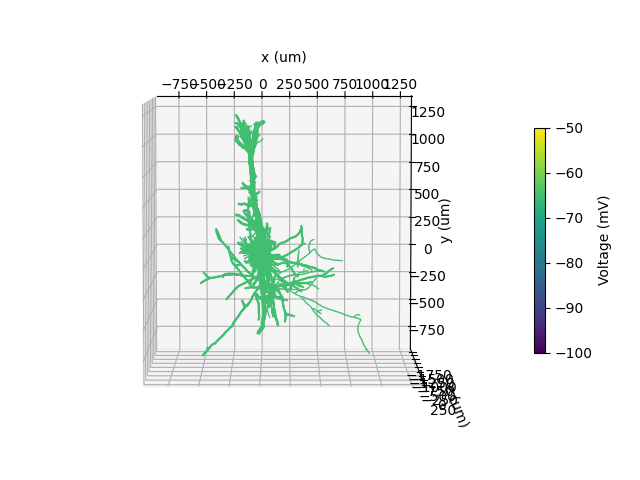

In [8]:
# netParams.rotateCellsRandomly = [0, 6.2832]
# sim.createSimulateAnalyze(netParams, cfg)

sys.path.append(rootFolder) # Reach out of "test" directory to access the rest of the code
from cfg import cfg
from netParams import netParams
from network_cell_choice import allpops

sim.initialize(
    simConfig=cfg, netParams=netParams
)  # create network object and set cfg and net params
sim.net.createPops()  # instantiate network populations
sim.net.createCells()  # instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()  # create connections between cells based on params
sim.net.addStims()  # add network stimulation
sim.setupRecording()  # setup variables to record for each cell (spikes, V traces, etc)
# cellsPost = sim.getCellsList(includePost)

fig, _ = sim.analysis.plotShape(
    includePre=allpops,
    includePost=allpops,
    includeAxon=True,
    showSyns=False,
    showElectrodes=False,
    cvar="voltage",
    dist=0.6,
    elev=95,
    azim=-90,
    axisLabels=True,
    synStyle="o",
    clim=[-100, -50],
    showFig=False,
    synSize=2,
)
# plt.show(); exit()

Add TMS

In [ ]:
# Add extracellular stim
from tms_tools import apply_tms

apply_tms(
    net=sim.net, 
    freq_Hz=50.,
    duration_ms=cfg.duration,
    pulse_resolution_ms=cfg.dt,
    tstart_ms=0.,
    ef_amp_V_per_m=1000.,
    width_ms=1.,
    pshape="Sine",
    decay_rate_percent_per_mm=10,
    E_field_dir=[-1, -1, -1],
    decay_dir=[0, 0, -1],
    ref_point_um=[0, 0, 0],
)

# Set up v_ext recording
vext_soma = []
vext_axon = []
for cell in sim.net.cells:
   ve_soma = h.Vector().record(cell.secs['soma_0']['hObj'](0)._ref_vext[0])
   ve_axon = h.Vector().record(cell.secs['Myelin_1']['hObj'](0.5)._ref_vext[0])
   vext_soma.append(ve_soma)
   vext_axon.append(ve_axon)
time = h.Vector().record(h._ref_t)


Testing external potentials (likely not useful as written)

In [ ]:
# cell = sim.net.cells[0]
# soma = cell.secs['soma_0']['hObj']
# axon = cell.secs['Myelin_1']['hObj']

# def get_seg_center(sec, arcpoint):
#     sec_num_pts = int(sec.n3d())  # number of 3d points for the current section
#     xx = []
#     yy = []
#     zz = []
#     length = []

#     # for each point, get x,y,z coordinates and arc length position.
#     for ii in range(0, sec_num_pts):
#         xx.append(sec.x3d(ii))
#         yy.append(sec.y3d(ii))
#         zz.append(sec.z3d(ii))
#         length.append(sec.arc3d(ii))

#     length = np.array(length)
#     if int(length[-1]) != 0:
#         length = length / (length[-1])

#     # numpy interp function: y = interp(x, xp, fp), where
#     # y are the interpolated values.
#     xint = np.interp(arcpoint, length, xx)
#     yint = np.interp(arcpoint, length, yy)
#     zint = np.interp(arcpoint, length, zz)
#     return np.array([xint, yint, zint])

# arcpoint = 0.5
# soma_pos = get_seg_center(soma, 0)
# axon_pos = get_seg_center(axon, arcpoint)

# print(soma_pos)
# print(axon_pos)

# amp = tms_params['amp']
# field_direction = np.array(tms_params['field_direction'])
# field_direction = field_direction / np.linalg.norm(field_direction)
# sigma = tms_params['sigma']
# decay_dir = tms_params['decay_dir']
# ref_point = np.array(tms_params['ref_point'])
# #ref_point = np.array(soma_pos)

# soma_scalar = (1 - sigma) ** np.dot((soma_pos - ref_point) / 1000, decay_dir)
# axon_scalar = (1 - sigma) ** np.dot((axon_pos - ref_point) / 1000, decay_dir)

# soma_root = np.array([soma.x3d(0), soma.y3d(0), soma.z3d(0)])

# axon_dist = axon_pos-soma_root
# # print(axon_dist)
# # print(field_direction)
# axon_elec_dist = np.dot(axon_dist, field_direction)
# #print(np.linalg.norm(axon_dist))
# # print(axon_elec_dist)

# exp_predicted_v_ext = -1 * amp * np.dot(field_direction, (axon_pos * axon_scalar) - (soma_pos * soma_scalar)) * 1e-6 * 1e3
# print(exp_predicted_v_ext)

# const_predicted_v_ext1 = -1 * amp * axon_elec_dist * 1e-6 * 1e3
# print(const_predicted_v_ext1)


Run sim

In [ ]:
sim.runSim()  # run parallel Neuron simulation
sim.gatherData()  # gather spiking data and cell info from each node
sim.saveData()  # save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  # plot spike raster etc
# sim.analysis.plotShape()

Plotting

In [ ]:
"""sim.analysis.plotLFP(**{'plots': ['timeSeries'], 
        'electrodes': [0], #'avg', 
        'timeRange': [350, cfg.duration], 
        'figSize': (12,4), 'saveFig': False, 'showFig': False})"""

"""sim.analysis.plotShape(includePre=['E'], includePost=['E'], includeAxon=False, showSyns=False, showElectrodes=[0],
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-80, -60], showFig=False, synSize=2)"""
"""sim.analysis.plotShape(includePre=allpops, includePost=allpops, includeAxon=True, showSyns=False, showElectrodes=False,
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-100, -50], showFig=False, synSize=2)"""

npoints = int(round(cfg.duration / cfg.dt)) + 1
time = np.linspace(0, cfg.duration, npoints)
print(list(time))
print(list(vext_soma[0]))

plt.figure()
plt.plot(list(time), list(vext_soma[0]), list(time), list(vext_axon[0]))
plt.title('V_ext')
plt.xlabel('Time (ms)')
plt.ylabel('Potential (mv)')
plt.legend(['Soma', 'Axon'])

# sim.analysis.plotTraces(
#     overlay=True, oneFigPer="trace", figSize=(12, 3), fontSize=15, saveFig=False
# )

#plt.show()